In [9]:
import numpy as np
import copy
import random
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [10]:
class NeuralNetwork:

    def __init__(self, input_size, output_size, hidden_layer_sizes, optimizer='adam'):
        self.layer_sizes = [input_size] + hidden_layer_sizes + [output_size]
        self.weights = []
        self.biases = []
        for layer_index in range(len(self.layer_sizes) - 1):
            self.weights.append(
                np.random.randn(self.layer_sizes[layer_index], self.layer_sizes[layer_index + 1])
                * np.sqrt(2. / self.layer_sizes[layer_index])
            )
            self.biases.append(np.zeros(self.layer_sizes[layer_index + 1]))

        self.optimizer = optimizer
        self.initialize_optimizer()

    def initialize_optimizer(self):
        if self.optimizer == 'adam':
            self.momentum_weights = [np.zeros_like(weight) for weight in self.weights]
            self.velocity_weights = [np.zeros_like(weight) for weight in self.weights]
            self.momentum_biases = [np.zeros_like(bias) for bias in self.biases]
            self.velocity_biases = [np.zeros_like(bias) for bias in self.biases]
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.time_step = 0

    def relu(self, input_value):
        return np.maximum(0, input_value)

    def relu_derivative(self, input_value):
        return (input_value > 0).astype(float)

    def sigmoid(self, input_value):
        return 1 / (1 + np.exp(-input_value))

    def compute_loss(self, true_labels, predicted_labels):
        return np.mean((true_labels - predicted_labels) ** 2)

    def forward_propagation(self, input_data):
        activations = [input_data]
        pre_activations = []

        for layer_index in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[layer_index]) + self.biases[layer_index]
            pre_activations.append(z)
            if layer_index == len(self.weights) - 1:
                activation = self.sigmoid(z)
            else:
                activation = self.relu(z)
            activations.append(activation)

        return activations, pre_activations

    def backpropagation(self, input_data, true_labels, activations, pre_activations):
        num_samples = true_labels.shape[0]
        deltas = [None] * len(self.weights)
        gradients_weights = [None] * len(self.weights)
        gradients_biases = [None] * len(self.biases)

        # Output layer delta (sigmoid derivative)
        deltas[-1] = (activations[-1] - true_labels) * (activations[-1] * (1 - activations[-1]))

        # Hidden layers delta
        for layer_index in reversed(range(len(deltas) - 1)):
            deltas[layer_index] = np.dot(deltas[layer_index + 1], self.weights[layer_index + 1].T) * self.relu_derivative(pre_activations[layer_index])

        # Gradients
        for layer_index in range(len(self.weights)):
            gradients_weights[layer_index] = np.dot(activations[layer_index].T, deltas[layer_index]) / num_samples
            gradients_biases[layer_index] = np.sum(deltas[layer_index], axis=0) / num_samples

        return gradients_weights, gradients_biases

    def update_parameters(self, gradients_weights, gradients_biases, learning_rate):
        if self.optimizer == 'adam':
            self.time_step += 1
            for layer_index in range(len(self.weights)):
                # Update biased first moments
                self.momentum_weights[layer_index] = self.beta1 * self.momentum_weights[layer_index] + (1 - self.beta1) * gradients_weights[layer_index]
                self.momentum_biases[layer_index] = self.beta1 * self.momentum_biases[layer_index] + (1 - self.beta1) * gradients_biases[layer_index]

                # Update biased second moments
                self.velocity_weights[layer_index] = self.beta2 * self.velocity_weights[layer_index] + (1 - self.beta2) * (gradients_weights[layer_index] ** 2)
                self.velocity_biases[layer_index] = self.beta2 * self.velocity_biases[layer_index] + (1 - self.beta2) * (gradients_biases[layer_index] ** 2)

                # Correct bias
                corrected_momentum_weights = self.momentum_weights[layer_index] / (1 - self.beta1 ** self.time_step)
                corrected_momentum_biases = self.momentum_biases[layer_index] / (1 - self.beta1 ** self.time_step)

                corrected_velocity_weights = self.velocity_weights[layer_index] / (1 - self.beta2 ** self.time_step)
                corrected_velocity_biases = self.velocity_biases[layer_index] / (1 - self.beta2 ** self.time_step)

                # Update parameters
                self.weights[layer_index] -= learning_rate * corrected_momentum_weights / (np.sqrt(corrected_velocity_weights) + self.epsilon)
                self.biases[layer_index] -= learning_rate * corrected_momentum_biases / (np.sqrt(corrected_velocity_biases) + self.epsilon)
        else:
            for layer_index in range(len(self.weights)):
                self.weights[layer_index] -= learning_rate * gradients_weights[layer_index]
                self.biases[layer_index] -= learning_rate * gradients_biases[layer_index]

    def train(self, input_data, true_labels, epochs, learning_rate, batch_size, X_test=None):
        num_samples = input_data.shape[0]

        best_loss = None
        best_weights = None
        best_biases = None

        pbar = tqdm(range(epochs))
        for epoch in pbar:
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            input_shuffled = input_data[indices]
            labels_shuffled = true_labels[indices]

            epoch_losses = []
            for batch_start in range(0, num_samples, batch_size):
                input_batch = input_shuffled[batch_start:batch_start + batch_size]
                labels_batch = labels_shuffled[batch_start:batch_start + batch_size]

                activations, pre_activations = self.forward_propagation(input_batch)
                gradients_weights, gradients_biases = self.backpropagation(input_batch, labels_batch, activations, pre_activations)
                self.update_parameters(gradients_weights, gradients_biases, learning_rate)

                batch_loss = self.compute_loss(labels_batch, self.forward_propagation(input_batch)[0][-1])
                epoch_losses.append(batch_loss)

            epoch_loss = float(np.mean(epoch_losses)) if len(epoch_losses) > 0 else 0.0

            # if a validation/test set is provided, compute its loss and keep the best model
            if X_test is not None:
                test_recon = self.reconstruct(X_test)
                test_loss = float(self.compute_loss(X_test, test_recon))
                if best_loss is None or test_loss < best_loss:
                    best_loss = test_loss
                    best_weights = copy.deepcopy(self.weights)
                    best_biases = copy.deepcopy(self.biases)
                pbar.set_description(f"Epoch {epoch+1}/{epochs} | Train {epoch_loss:.4f} | Test {test_loss:.4f} | Best {best_loss:.4f}")
            else:
                pbar.set_description(f"Epoch {epoch+1}/{epochs} | Train {epoch_loss:.4f}")

        if best_weights is not None:
            self.weights = best_weights
            self.biases = best_biases
            print(f"Restored best model with Test Loss = {best_loss:.6f}")


    def reconstruct(self, input_data):
        activations, _ = self.forward_propagation(input_data)
        return activations[-1]

In [11]:
def set_global_seed(seed=17):
    np.random.seed(seed)
    random.seed(seed)

set_global_seed()

In [12]:
def process_image(path, img_size=28):
    img = Image.open(path).convert("L")
    img = img.resize((img_size, img_size))
    img_array = np.array(img, dtype=np.float32) / 255.0
    return img_array.flatten()

def load_data_from_csv(csv_path, img_size=28, max_workers=8):
    df = pd.read_csv(csv_path)
    df['filename'] = df['filename'].apply(
        lambda x: "/kaggle/input/hindi-mnist-data/DevanagariHandwrittenDigitDataset/" + x
    )
    image_paths = df['filename'].values
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        images = list(tqdm(
            executor.map(lambda p: process_image(p, img_size), image_paths),
            total=len(image_paths),
            desc="Loading images"
        ))

    X = np.stack(images)
    X_train, X_temp = train_test_split(X, test_size=0.4, random_state=17)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=17)
    return X_train, X_val, X_test

In [13]:
csv_path = "/kaggle/input/hindi-mnist-data/hindi_mnist.csv"
print("Loading dataset from:", csv_path)
X_train, X_val, X_test = load_data_from_csv(csv_path)
print("Shapes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Loading dataset from: /kaggle/input/hindi-mnist-data/hindi_mnist.csv


Loading images: 100%|██████████| 20000/20000 [00:17<00:00, 1143.16it/s]


Shapes -> Train: (12000, 784) Val: (4000, 784) Test: (4000, 784)


Training: latent=32, lr=0.1, epochs=400


Epoch 400/400 | Train 0.2250 | Test 0.2244 | Best 0.2244: 100%|██████████| 400/400 [50:03<00:00,  7.51s/it]


Restored best model with Test Loss = 0.224448
Test MSE (latent=32, lr=0.1, epochs=400): 0.224729


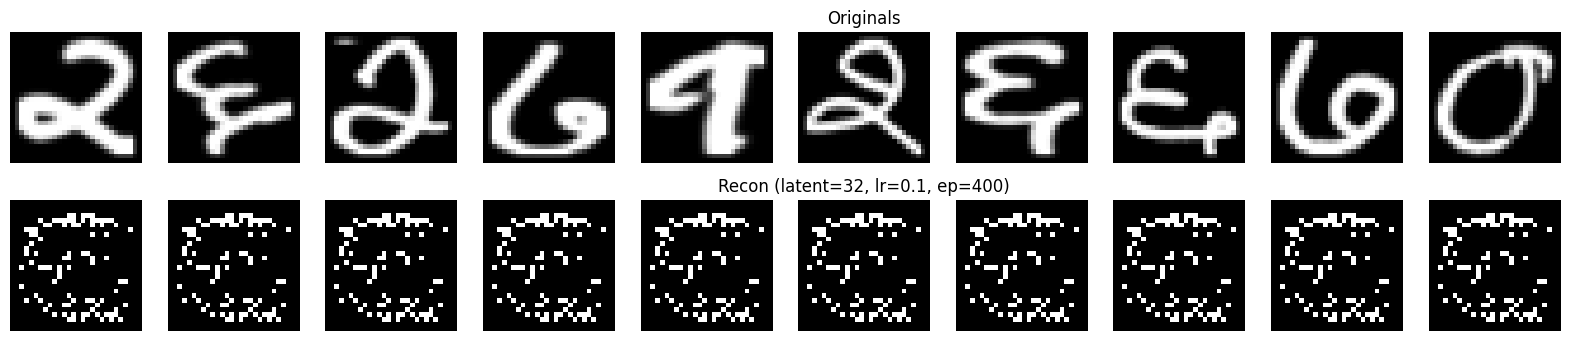

Training: latent=32, lr=0.01, epochs=400


Epoch 400/400 | Train 0.2238 | Test 0.2231 | Best 0.2228: 100%|██████████| 400/400 [48:21<00:00,  7.25s/it]


Restored best model with Test Loss = 0.222753
Test MSE (latent=32, lr=0.01, epochs=400): 0.223215


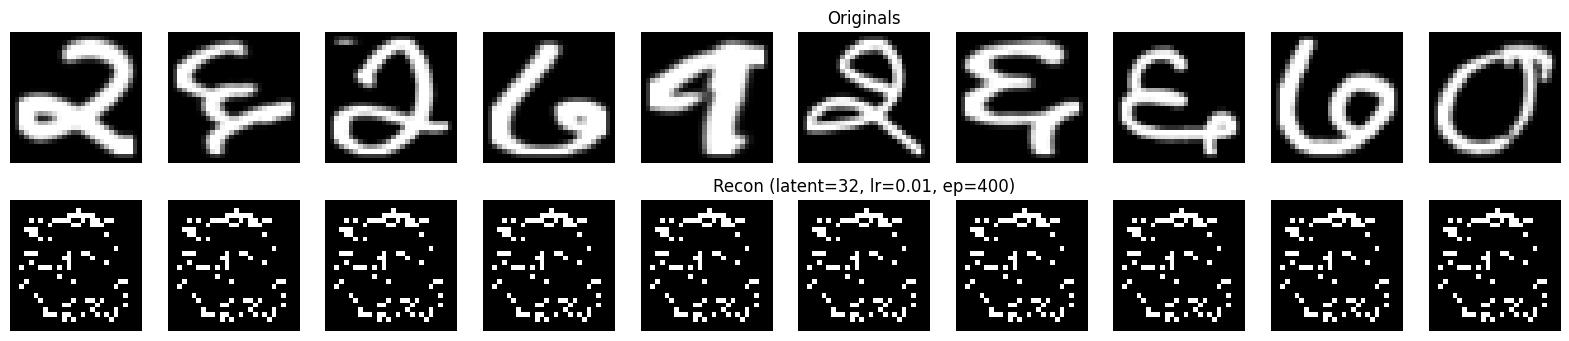

Training: latent=32, lr=0.001, epochs=400


Epoch 400/400 | Train 0.0059 | Test 0.0213 | Best 0.0203: 100%|██████████| 400/400 [30:52<00:00,  4.63s/it]


Restored best model with Test Loss = 0.020283
Test MSE (latent=32, lr=0.001, epochs=400): 0.020077


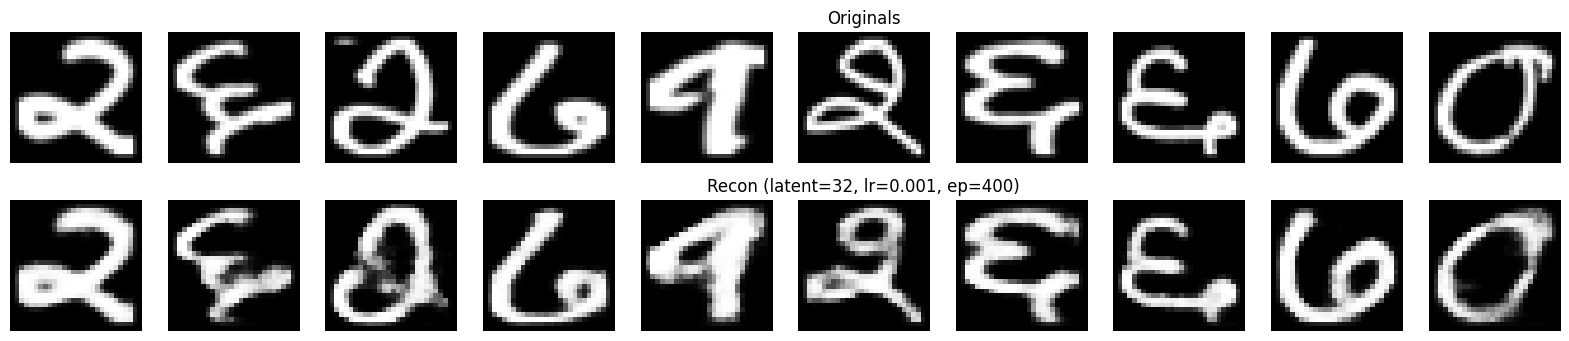

Training: latent=32, lr=0.0001, epochs=400


Epoch 400/400 | Train 0.0186 | Test 0.0249 | Best 0.0249: 100%|██████████| 400/400 [30:51<00:00,  4.63s/it]


Restored best model with Test Loss = 0.024891
Test MSE (latent=32, lr=0.0001, epochs=400): 0.024743


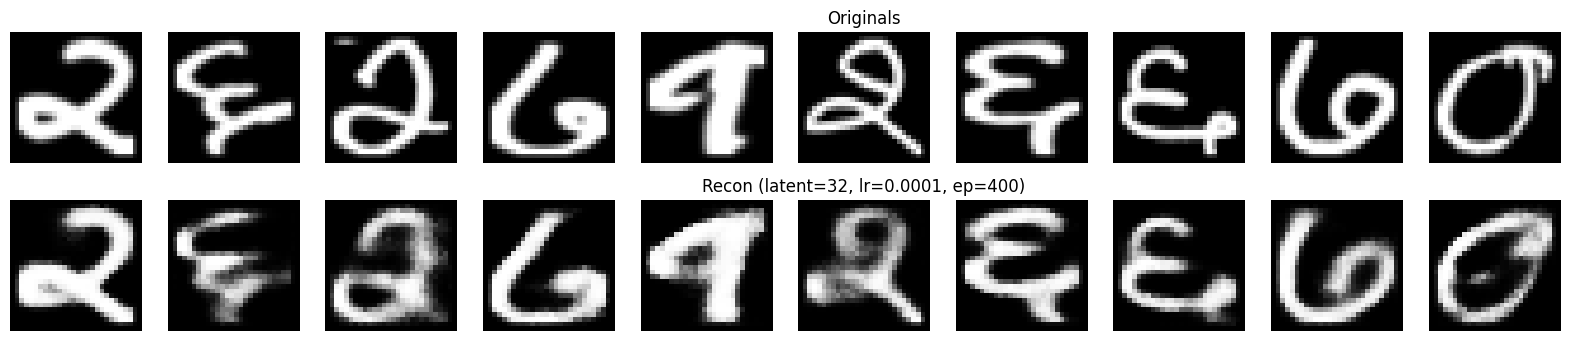

Training: latent=16, lr=0.1, epochs=400


Epoch 400/400 | Train 0.2152 | Test 0.2146 | Best 0.2146: 100%|██████████| 400/400 [48:57<00:00,  7.34s/it]


Restored best model with Test Loss = 0.214577
Test MSE (latent=16, lr=0.1, epochs=400): 0.214766


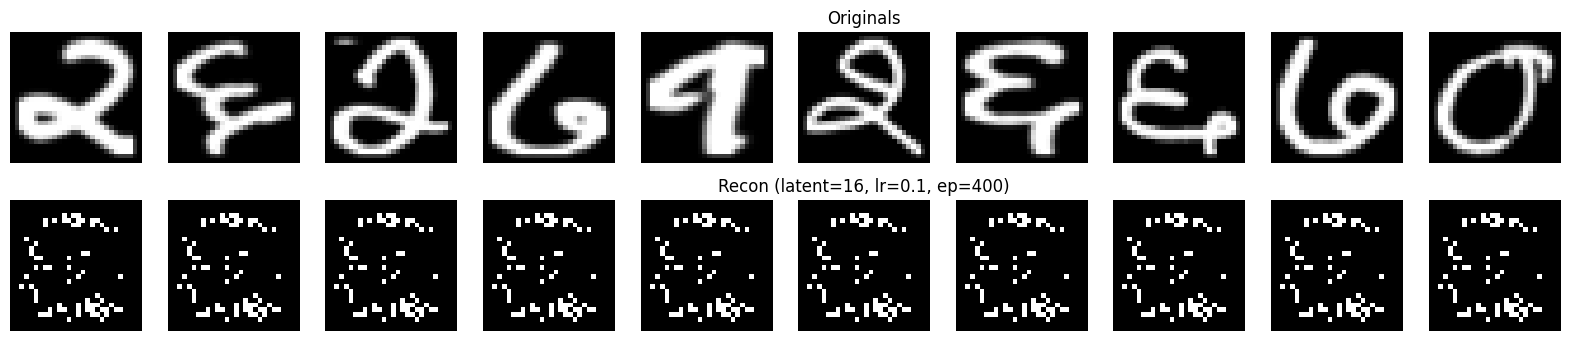

Training: latent=16, lr=0.01, epochs=400


Epoch 400/400 | Train 0.2107 | Test 0.2101 | Best 0.2101: 100%|██████████| 400/400 [45:08<00:00,  6.77s/it]


Restored best model with Test Loss = 0.210103
Test MSE (latent=16, lr=0.01, epochs=400): 0.210395


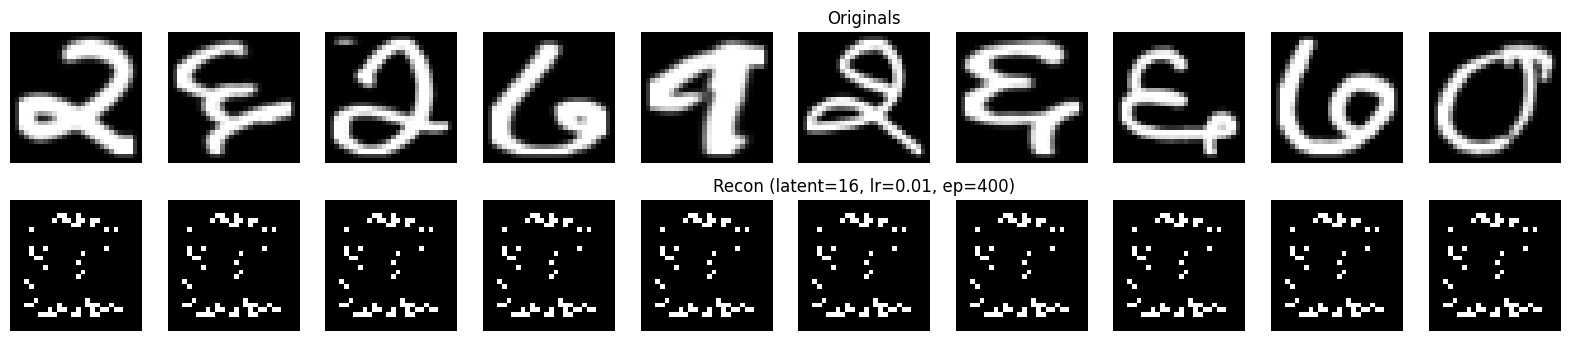

Training: latent=16, lr=0.001, epochs=400


Epoch 400/400 | Train 0.0102 | Test 0.0350 | Best 0.0325: 100%|██████████| 400/400 [28:47<00:00,  4.32s/it]


Restored best model with Test Loss = 0.032478
Test MSE (latent=16, lr=0.001, epochs=400): 0.031969


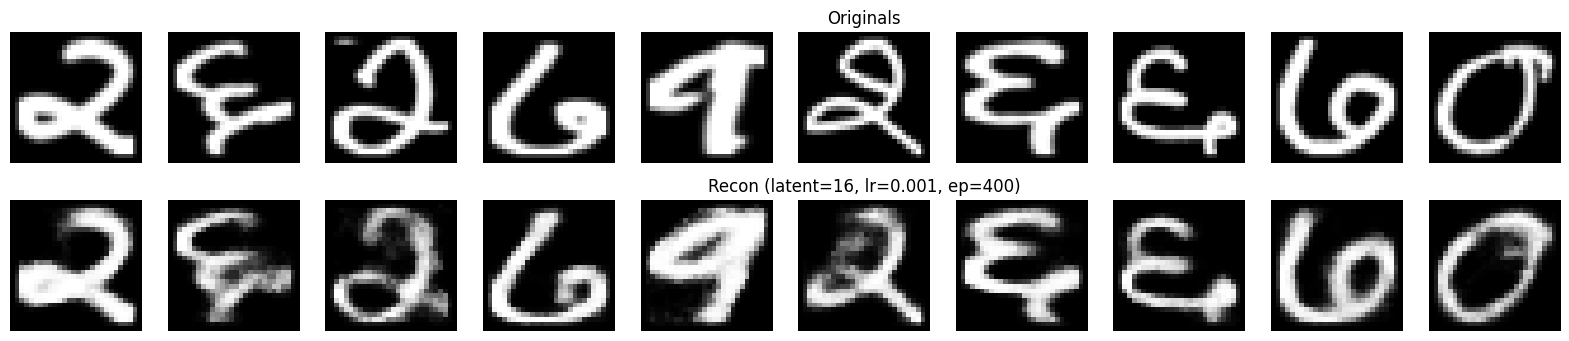

Training: latent=16, lr=0.0001, epochs=400


Epoch 400/400 | Train 0.0227 | Test 0.0312 | Best 0.0311: 100%|██████████| 400/400 [29:08<00:00,  4.37s/it]


Restored best model with Test Loss = 0.031107
Test MSE (latent=16, lr=0.0001, epochs=400): 0.030965


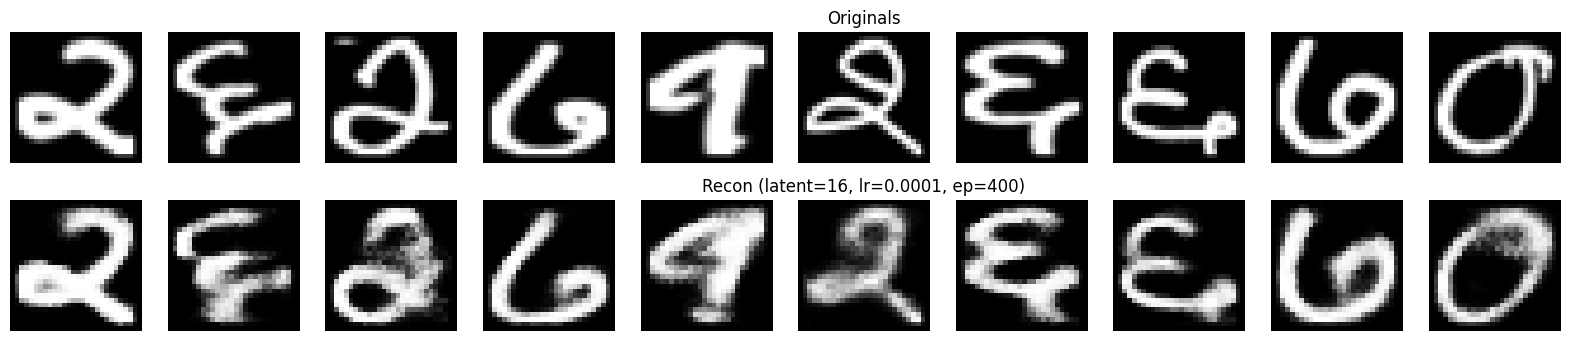

Training: latent=4, lr=0.1, epochs=400


Epoch 400/400 | Train 0.2649 | Test 0.2645 | Best 0.2645: 100%|██████████| 400/400 [45:02<00:00,  6.76s/it]


Restored best model with Test Loss = 0.264500
Test MSE (latent=4, lr=0.1, epochs=400): 0.264585


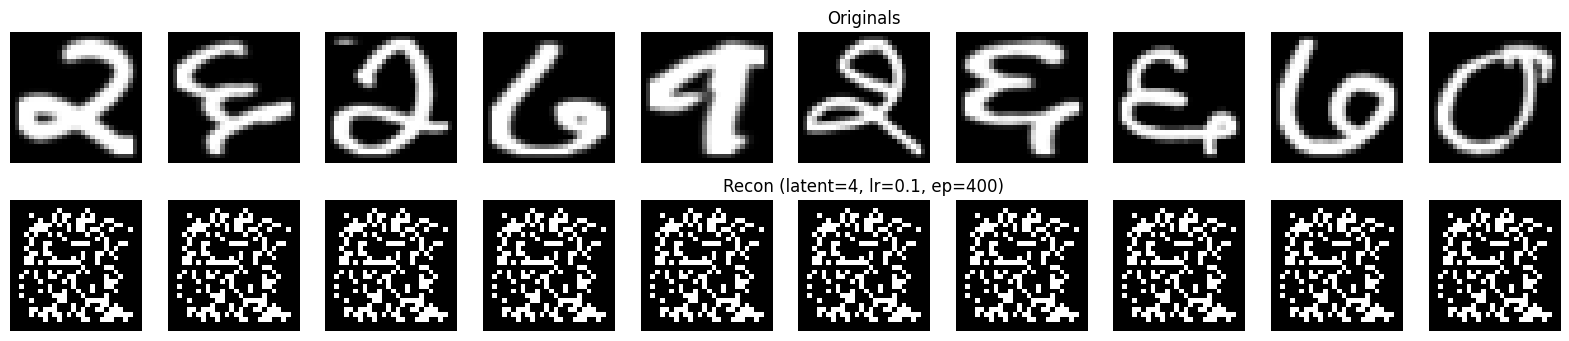

Training: latent=4, lr=0.01, epochs=400


Epoch 400/400 | Train 0.1175 | Test 0.1172 | Best 0.1172: 100%|██████████| 400/400 [32:16<00:00,  4.84s/it]


Restored best model with Test Loss = 0.117229
Test MSE (latent=4, lr=0.01, epochs=400): 0.117284


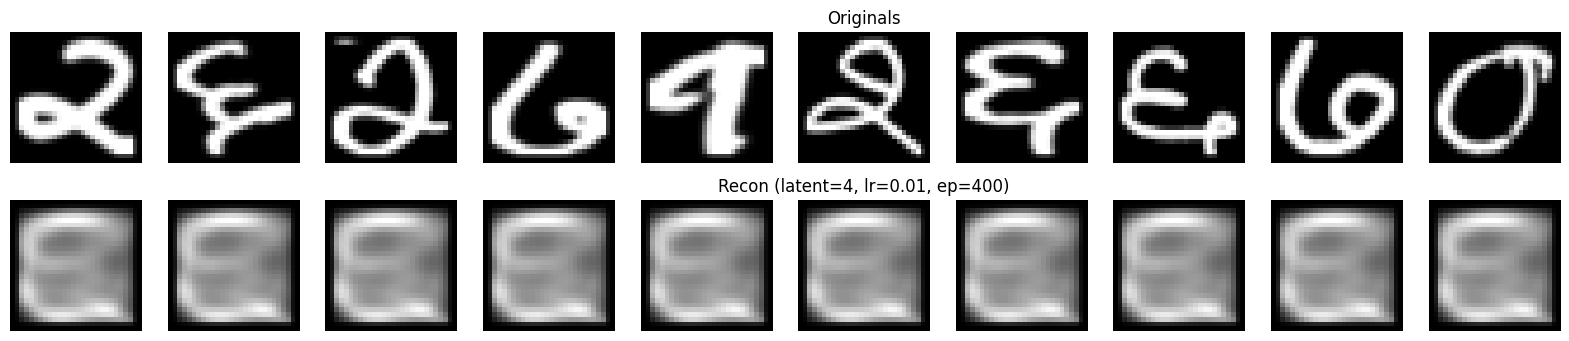

Training: latent=4, lr=0.001, epochs=400


Epoch 400/400 | Train 0.0464 | Test 0.0561 | Best 0.0555: 100%|██████████| 400/400 [28:20<00:00,  4.25s/it]


Restored best model with Test Loss = 0.055523
Test MSE (latent=4, lr=0.001, epochs=400): 0.055761


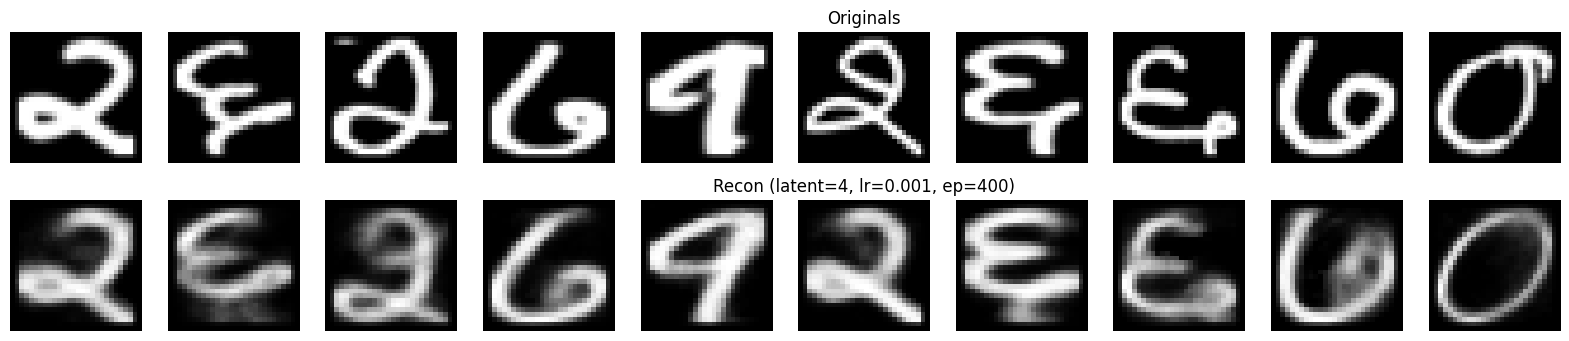

Training: latent=4, lr=0.0001, epochs=400


Epoch 400/400 | Train 0.0478 | Test 0.0644 | Best 0.0639: 100%|██████████| 400/400 [28:36<00:00,  4.29s/it]


Restored best model with Test Loss = 0.063891
Test MSE (latent=4, lr=0.0001, epochs=400): 0.063286


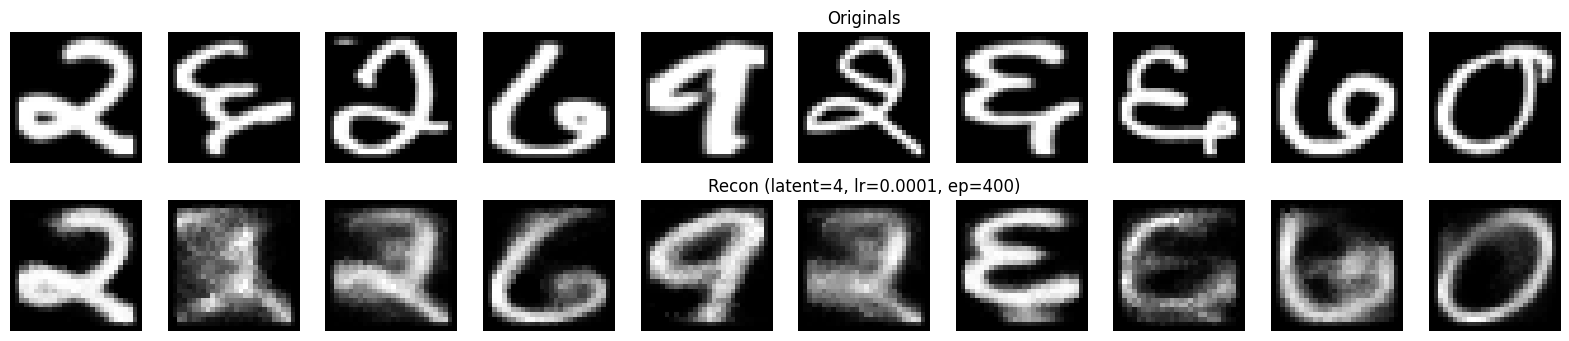

Training: latent=1, lr=0.1, epochs=400


Epoch 400/400 | Train 0.2223 | Test 0.2221 | Best 0.2221: 100%|██████████| 400/400 [45:37<00:00,  6.84s/it]


Restored best model with Test Loss = 0.222106
Test MSE (latent=1, lr=0.1, epochs=400): 0.221812


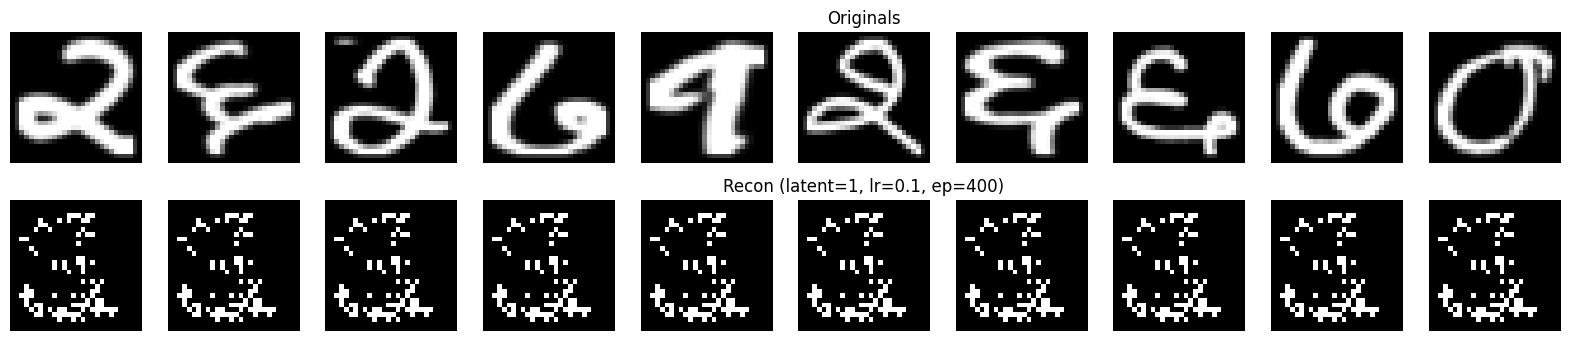

Training: latent=1, lr=0.01, epochs=400


Epoch 400/400 | Train 0.1175 | Test 0.1172 | Best 0.1172: 100%|██████████| 400/400 [31:59<00:00,  4.80s/it]


Restored best model with Test Loss = 0.117226
Test MSE (latent=1, lr=0.01, epochs=400): 0.117284


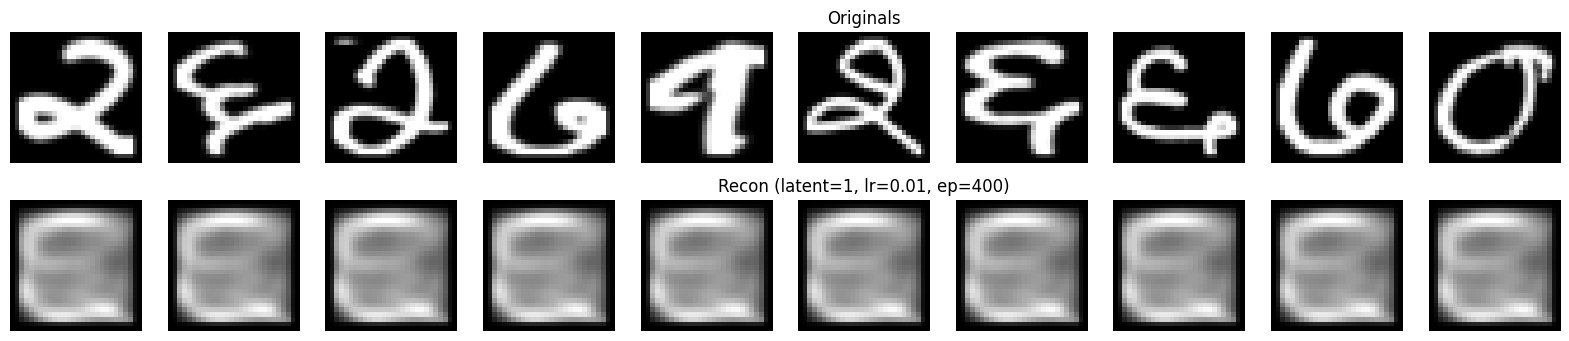

Training: latent=1, lr=0.001, epochs=400


Epoch 400/400 | Train 0.1175 | Test 0.1172 | Best 0.1172: 100%|██████████| 400/400 [31:28<00:00,  4.72s/it]


Restored best model with Test Loss = 0.117228
Test MSE (latent=1, lr=0.001, epochs=400): 0.117286


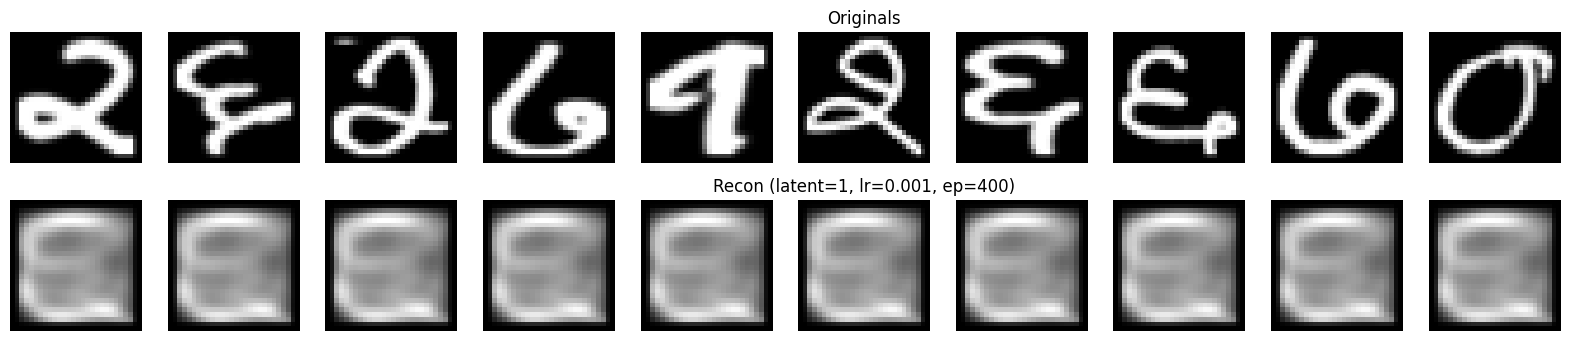

Training: latent=1, lr=0.0001, epochs=400


Epoch 400/400 | Train 0.1175 | Test 0.1172 | Best 0.1172: 100%|██████████| 400/400 [31:44<00:00,  4.76s/it]


Restored best model with Test Loss = 0.117227
Test MSE (latent=1, lr=0.0001, epochs=400): 0.117285


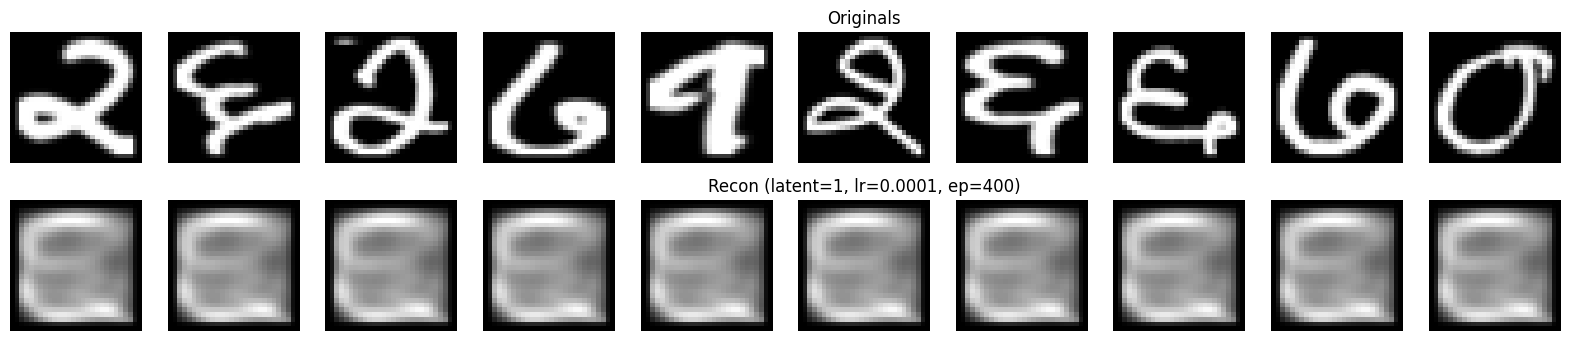

In [35]:
input_dim = 784

latent_dims = [32, 16, 4, 1]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
epoch_candidates = [400]
batch_size = 512
hidden_template = [784, 392, 196, 98, 49]

results = {}

for latent_dim in latent_dims:
    results[latent_dim] = {}

    for lr in learning_rates:
        results[latent_dim][lr] = {}
        for epochs in epoch_candidates:
            print(f"Training: latent={latent_dim}, lr={lr}, epochs={epochs}")
            
            # assemble full hidden layers with latent in the middle
            hidden_layers = hidden_template + [latent_dim] + hidden_template[::-1]

            # re-seed so each run starts from same initialization when requested
            set_global_seed(17)
            model = NeuralNetwork(input_size=input_dim, output_size=input_dim, hidden_layer_sizes=hidden_layers, optimizer='adam')

            model.train(X_train, X_train, epochs=epochs, learning_rate=lr, batch_size=batch_size, X_test=X_val)

            # evaluate on held-out test set
            reconstructed = model.reconstruct(X_test)
            mse = float(mean_squared_error(X_test, reconstructed))
            print(f"Test MSE (latent={latent_dim}, lr={lr}, epochs={epochs}): {mse:.6f}")

            results[latent_dim][lr][epochs] = {'mse': mse}

            n_show = 10
            fig, axes = plt.subplots(2, n_show, figsize=(20, 4))
            for i in range(n_show):
                axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
                axes[0, i].axis('off')
                if i == n_show//2:
                    axes[0, i].set_title(f'Originals')
                axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
                axes[1, i].axis('off')
                if i == n_show//2:
                    axes[1, i].set_title(f'Recon (latent={latent_dim}, lr={lr}, ep={epochs})')
            plt.show()

In [14]:
best_conf = None
best_mse = float('inf')
for latent in results:
    for lr in results[latent]:
        for ep in results[latent][lr]:
            if results[latent][lr][ep]['mse'] < best_mse:
                best_mse = results[latent][lr][ep]['mse']
                best_conf = (latent, lr, ep)

print("Best config (by Test MSE):", best_conf, "mse=", best_mse)

Best config (by Test MSE): (32, 0.001, 400) mse= 0.020077


In [15]:
best_latent = best_conf[0]
print("Fitting PCA with n_components=", best_latent)
pca = PCA(n_components=best_latent, random_state=17)
pca.fit(X_train)
X_test_pca_recon = pca.inverse_transform(pca.transform(X_test))

pca_mse = mean_squared_error(X_test, X_test_pca_recon)
print(f"PCA reconstruction MSE (latent={best_latent}): {pca_mse:.6f}")

Fitting PCA with n_components= 32
PCA reconstruction MSE (latent=32): 0.028476


In [28]:
latent, lr, epochs = best_conf
hidden_layers = hidden_template + [latent] + hidden_template[::-1]
set_global_seed(17)
final_ae = NeuralNetwork(input_size=input_dim, output_size=input_dim, hidden_layer_sizes=hidden_layers, optimizer='adam')
final_ae.train(X_train, X_train, epochs=epochs, learning_rate=lr, batch_size=batch_size, X_test=X_val)
final_recon = final_ae.reconstruct(X_test)

Epoch 400/400 | Train 0.0059 | Test 0.0213 | Best 0.0203: 100%|██████████| 400/400 [33:08<00:00,  4.97s/it]


Restored best model with Test Loss = 0.020283


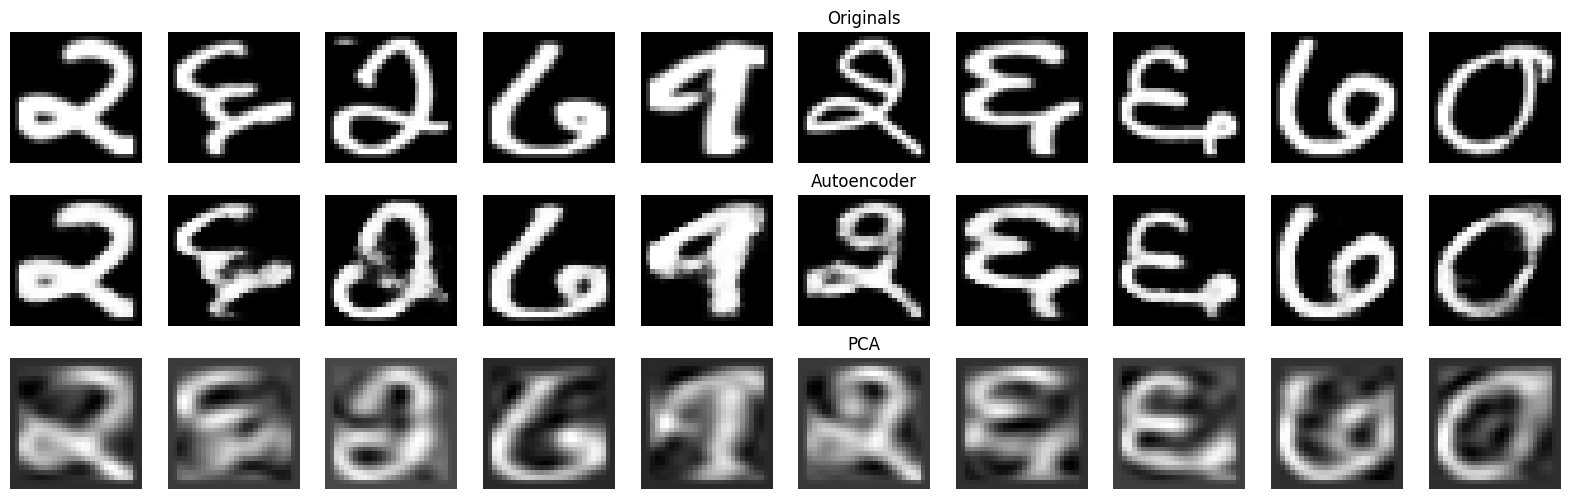

In [29]:
n_show = 10
fig, axes = plt.subplots(3, n_show, figsize=(20, 6))
for i in range(n_show):
    axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == n_show//2:
        axes[0, i].set_title('Originals')

    axes[1, i].imshow(final_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == n_show//2:
        axes[1, i].set_title('Autoencoder')

    axes[2, i].imshow(X_test_pca_recon[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == n_show//2:
        axes[2, i].set_title('PCA')

plt.show()